<a href="https://colab.research.google.com/github/Oleg007003/StyleTransfernetwork/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!wget https://funart.pro/uploads/posts/2020-04/1587636492_24-p-foni-mainkraft-73.jpg
!wget https://cdn.wallpapersafari.com/54/89/bitxop.jpg

--2021-04-14 16:31:01--  https://funart.pro/uploads/posts/2020-04/1587636492_24-p-foni-mainkraft-73.jpg
Resolving funart.pro (funart.pro)... 146.59.4.246
Connecting to funart.pro (funart.pro)|146.59.4.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146450 (143K) [image/jpeg]
Saving to: ‘1587636492_24-p-foni-mainkraft-73.jpg’

1587636492_24-p-fon 100%[===================>] 143.02K   594KB/s    in 0.2s    

2021-04-14 16:31:02 (594 KB/s) - ‘1587636492_24-p-foni-mainkraft-73.jpg’ saved [146450/146450]

--2021-04-14 16:31:02--  https://cdn.wallpapersafari.com/54/89/bitxop.jpg
Resolving cdn.wallpapersafari.com (cdn.wallpapersafari.com)... 104.26.11.233, 172.67.74.226, 104.26.10.233, ...
Connecting to cdn.wallpapersafari.com (cdn.wallpapersafari.com)|104.26.11.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324902 (317K) [image/jpeg]
Saving to: ‘bitxop.jpg’

bitxop.jpg          100%[===================>] 317.29K   752KB/s    in 0.4s

In [6]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = image.resize((1600, 1200))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./bitxop.jpg")
content_img = image_loader("./1587636492_24-p-foni-mainkraft-73.jpg")


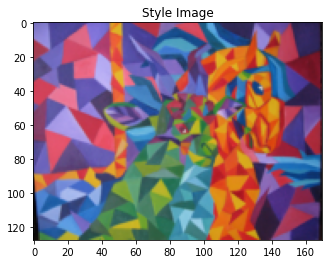

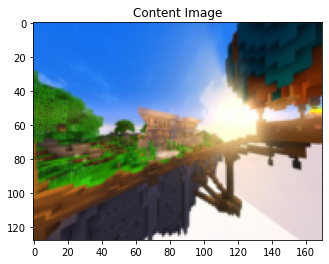

In [7]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

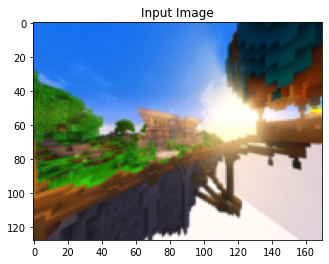

In [17]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [14]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=350,
                       style_weight=250000, content_weight=1):
    """ Поехали! """
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():

            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Optimizing..
run [50]:
Style Loss : 221.321625 Content Loss: 37.864532

run [100]:
Style Loss : 59.931366 Content Loss: 40.314251

run [150]:
Style Loss : 30.089300 Content Loss: 40.469807

run [200]:
Style Loss : 19.726463 Content Loss: 39.343231

run [250]:
Style Loss : 14.693880 Content Loss: 38.073849

run [300]:
Style Loss : 12.068743 Content Loss: 37.017559

run [350]:
Style Loss : 10.241870 Content Loss: 36.181152



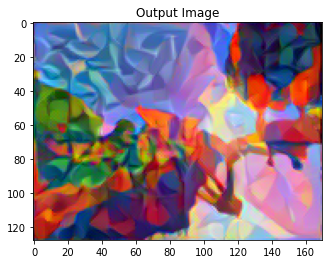

In [18]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)


imshow(output, title='Output Image')

plt.show()

In [19]:
!rm "bitxop.jpg"
!rm "1587636492_24-p-foni-mainkraft-73.jpg"